In [199]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision
from torchvision import transforms
# import matplotlib.pyplot as plot
from random import shuffle
#from google.colab import drive                IF you are using COLAB

In [2]:
# Use this if you are working on COLAB
# This will prompt for authorization.
#drive.mount('/content/drive')

In [3]:
def extract_data(x_data_filepath, y_data_filepath):
    X = np.load(x_data_filepath)
    y = np.load(y_data_filepath)
    return X, y

In [4]:
def data_visualization(images,labels):
    """
    Visualize 6 pictures per class using your prefered visulization library (matplotlib, etc)

    Args:
    images: training images in shape (num_images,3,image_H,image_W)
    labels: training labels in shape (num_images,)
    """
    img_labels = [int(x) for x in labels]
    label0 = [x for x, label in enumerate(img_labels) if label == 0]
    label1 = [x for x, label in enumerate(img_labels) if label == 1]
    label2 = [x for x, label in enumerate(img_labels) if label == 2]
    label3 = [x for x, label in enumerate(img_labels) if label == 3]
    label4 = [x for x, label in enumerate(img_labels) if label == 4]

    label_lst = [label0, label1, label2, label3, label4]

    for i in range(6): #select the first 6 pics
        for label in label_lst: #iterate over each label
            plt.imshow(np.swapaxes(images[label[i]].T,0,1))
            plt.show()


    pass

In [74]:
############################################################
# Extracting and loading data
############################################################
class Dataset(Dataset):
    def __init__(self, X, y):
        self.len = len(X)           
        if torch.cuda.is_available():
          self.x_data = torch.from_numpy(X).float().cuda()
          self.y_data = torch.from_numpy(y).long().cuda()
        else:
          self.x_data = torch.from_numpy(X).float()
          self.y_data = torch.from_numpy(y).long()
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [90]:
def create_validation(x_train,y_train):
    """
    Randomly choose 20 percent of the training data as validation data.

    Args:
        x_train: training images in shape (num_images,3,image_H,image_W)
        y_train: training labels in shape (num_images,)
    Returns:
        new_x_train: training images in shape (0.8*num_images,3,image_H,image_W)
        new_y_train: training labels in shape (0.8*num_images,)
        x_val: validation images in shape (0.2*num_images,3,image_H,image_W)
        y_val: validation labels in shape (0.2*num_images,)
    """
#     dataset = Dataset(x_train, y_train)
    #shuffle the list of indices of the dataset - prep for the split of valid and train sets

    indices = list(range(len(x_train)))
    shuffle(indices)
    valid_size = int(np.floor(0.2 * len(x_train)))
#     x_val = dataset.x_data[indices[:valid_size]]
    x_val = x_train[indices[:valid_size]]    
#     y_val = dataset.y_data[indices[:valid_size]]
    y_val = y_train[indices[:valid_size]]
#     new_x_train = dataset.x_data[indices[valid_size:]]
    new_x_train = x_train[indices[valid_size:]]
#     new_y_train = dataset.y_data[indices[valid_size:]]
    new_y_train = y_train[indices[valid_size:]]
    
    return new_x_train,new_y_train,x_val,y_val

In [83]:
# x_train, y_train = extract_data('data/images_train.npy','data/labels_train.npy')

In [95]:

# #shuffle the list of indices of the dataset - prep for the split of valid and train sets
# x_train, y_train, x_val, y_val = create_validation(images, labels)
# y_val.shape

(520,)

In [81]:
# x_train.size()

torch.Size([2081, 3, 64, 85])

In [7]:
############################################################
# Feed Forward Neural Network
############################################################
class FeedForwardNN(nn.Module):
    """ 
        (1) Use self.fc1 as the variable name for your first fully connected layer
        (2) Use self.fc2 as the variable name for your second fully connected layer
    """
    def __init__(self):
        super(FeedForwardNN,self).__init__()
        self.fc1 = nn.Linear(16320,2000)
        self.fc2 = nn.Linear(2000,5)
        

    def forward(self, x):
        #reshape to (16320,1)
        x_reshape = x.view(x.size(0),-1)
        fc1_output = F.relu(self.fc1(x_reshape))
        out = self.fc2(fc1_output)
        return out

    """ 
        Please do not change the functions below. 
        They will be used to test the correctness of your implementation 
    """
    def get_fc1_params(self):
        return self.fc1.__repr__()
    
    def get_fc2_params(self):
        return self.fc2.__repr__()

In [156]:
############################################################
# Convolutional Neural Network
############################################################
class ConvolutionalNN(nn.Module):
    """ 
        (1) Use self.conv1 as the variable name for your first convolutional layer
        (2) Use self.pool1 as the variable name for your first pooling layer
        (3) Use self.conv2 as the variable name for your second convolutional layer
        (4) Use self.pool2 as the variable name for you second pooling layer  
        (5) Use self.fc1 as the variable name for your first fully connected laye
        (6) Use self.fc2 as the variable name for your second fully connected layer
    """
    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        
        #cnn
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3)
        #maxpooling 2d
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        #fully connected layer
        self.fc1 = nn.Linear(8512, 200)
        self.fc2 = nn.Linear(200, 5)
        
    def forward(self, x):
        x_np = x.numpy()
        x = normalize_image(x)
        #relu + maxpool first layer
        relu1 = F.relu(self.cnn1(x))
        maxpooling1 = self.pool1(relu1)
        #relu + maxpool second layer
        relu2 = F.relu(self.cnn2(maxpooling1))
        maxpooling2 = self.pool2(relu2)
        #flatten image
        reshape = maxpooling2.view(maxpooling2.size(0),-1)
        #fully connected layer - output
        fc1_output = F.relu(self.fc1(reshape))
        out = self.fc2(fc1_output)
        return out
      
    """ 
        Please do not change the functions below. 
        They will be used to test the correctness of your implementation
    """
    
    def get_conv1_params(self):
        return self.conv1.__repr__()
    
    def get_pool1_params(self):
        return self.pool1.__repr__()

    def get_conv2_params(self):
        return self.conv2.__repr__()
      
    def get_pool2_params(self):
        return self.pool2.__repr__()
      
    def get_fc1_params(self):
        return self.fc1.__repr__()
    
    def get_fc2_params(self):
        return self.fc2.__repr__()

In [97]:
def normalize_image(image):
    """
    Normalize each input image

    Args:
        image: the input image in shape (3,image_H,image_W)
    Returns:
        norimg: the normalized image in the same shape as the input
    """
#     image = image.numpy()
    
    rbg_mean = []
    rbg_std = []
    for i in range(0,3):
        mean =  np.mean(image[i,:,:])
        std = np.std(image[i,:,:])
        image[i,:,:] = (image[i,:,:] - mean)/std
    
    norimg = image
    
    


    return (norimg)

In [186]:
############################################################
# Optimized Neural Network
############################################################
class OptimizedNN(nn.Module):
    def __init__(self):
        super(OptimizedNN, self).__init__()
        #cnn
        self.cnn1 = nn.Conv2d(3, 16, kernel_size = 3)
        self.cnn2 = nn.Conv2d(16, 32, kernel_size = 3)
        self.cnn3 = nn.Conv2d(32, 64, kernel_size = 3)
        #maxpooling 2d
        self.pool = nn.MaxPool2d(kernel_size = 2)
        #fully connected layer
        self.fc1 = nn.Linear(3072, 200)
        self.fc2 = nn.Linear(200, 5)
        #dropout
        self.drop_out1 = nn.Dropout(p = 0.5)
        self.drop_out2 = nn.Dropout(p = 0.5)

        
    def forward(self, x):
#         x_np = x.numpy()
#         x = normalize_image(x)
#         print(type(x))
#         x = torch.from_numpy(x)
        #relu + maxpool first layer
        relu1 = F.relu(self.cnn1(x))
        maxpooling1 = self.pool(relu1)
        
        #relu + maxpool second layer
        relu2 = F.relu(self.cnn2(maxpooling1))
        maxpooling2 = self.pool(relu2)
        
        #relu + maxpool second layer
        relu3 = F.relu(self.cnn3(maxpooling2))
        maxpooling3 = self.pool(relu3)
        
        #flatten image
        reshape = maxpooling3.view(maxpooling3.size(0),-1)
        #fully connected layer - output
        fc1_output = self.drop_out1(reshape)
        fc1_output = F.relu(self.fc1(fc1_output))
        fc2_output = self.drop_out2(fc1_output)
        out = self.fc2(fc2_output)
        
        return out
      

In [11]:
def train_val_NN(neural_network, train_loader, validation_loader, loss_function, optimizer,num_epochs):
    """
    Runs experiment on the model neural network given a train loader, loss function and optimizer and find validation accuracy for each epoch given the validation_loader.

    Args:
        neural_network (NN model that extends torch.nn.Module): For example, it should take an instance of either
                                                                FeedForwardNN or ConvolutionalNN,
        train_loader (DataLoader),
        validation_loader (DataLoader),
        loss_function (torch.nn.CrossEntropyLoss),
        optimizer (optim.SGD)
        num_epochs (number of iterations)
    Returns:
        tuple: First position, training accuracies of each epoch formatted in an array of shape (num_epochs,1).
               Second position, training loss of each epoch formatted in an array of shape (num_epochs,1).
               third position, validation accuracy of each epoch formatted in an array of shape (num_epochs,1).
               
    """
    #initialize variables
    accuracy = np.zeros((num_epochs, 1))
    loss_np = np.zeros((num_epochs,1))
    val_accuracy = np.zeros((num_epochs, 1))
    iter_num = 0
    
    ########################## TRAINING SET ########################## 
    for epoch in range(num_epochs):
        training_loss = []
        correct = 0
        total = 0
        neural_network.train()
        for i, data in enumerate(train_loader,0):
            #get the inputs
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()
             
            # forward + backward + optimize
            outputs = neural_network(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss.append(loss.item())
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
        #calculate the accuracy rate for each epoch    
        accuracy[iter_num] =  correct/total
        loss_np[iter_num] = np.mean(training_loss)

        
        ########################## EVALUATION SET ########################## 
        #re-initialize 'correct'
        correct = 0
        total = 0
        neural_network.eval()
        for i, data in enumerate(validation_loader,0):
            #get the inputs
            inputs, labels = data
            
            # forward + backward + optimize
            outputs = neural_network(inputs)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
        val_accuracy[iter_num] = correct/total
        
        iter_num +=1
        
  
    return accuracy,loss_np,val_accuracy


In [196]:
def test_NN(neural_network, test_loader):
  
    """
    Runs experiment on the model neural network given a test loader, loss function and optimizer.

    Args:
        neural_network (NN model that extends torch.nn.Module): For example, it should take an instance of either
                                                                FeedForwardNN or ConvolutionalNN,
        test_loader (DataLoader), (make sure the loader is not shuffled)
        loss_function (torch.nn.CrossEntropyLoss),
        optimizer (your choice)
        num_epochs (number of iterations)
    Returns:
        your predictions         
    """
    
    neural_network.eval()
    Preds = torch.LongTensor()

    for _, data in enumerate(test_loader):
        data = data[0]
        outputs = neural_network(data)
#         pred,_ = torch.max(outputs.data, 1)
        _,pred = torch.max(outputs.data, 1)
#         _,pred= outputs.data.max(1, keepdim = True)
        Preds = torch.cat((Preds, pred), dim = 0)
  
    return Preds

In [197]:
model = OptimizedNN()
test = np.load('data/images_test.npy')
test = torch.tensor(test, dtype = torch.float32)
test = torch.utils.data.TensorDataset(test)

test_loader = DataLoader(test, batch_size = 32)
# print(test_loader)
Preds = test_NN(model, test_loader)

In [198]:
# with open('HW4_preds.txt','w', encoding = 'utf8') as file:
#     for i in range(len(test_loader.dataset)):
#         file.write(str(Preds[i].item())+'\n')

In [13]:
# Run Baseline FeedForward
# images, labels = extract_data('data/images_train.npy','data/labels_train.npy')
# x_train, y_train, x_val, y_val = create_validation(images, labels)
# train_set = torch.utils.data.TensorDataset(x_train, y_train)
# val_set = torch.utils.data.TensorDataset(x_val, y_val)
# train_loader = DataLoader(train_set, batch_size = 64)
# validation_loader = DataLoader(val_set, batch_size = 64)

# num_epochs = 40
# ff_nn= FeedForwardNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adagrad(ff_nn.parameters(), lr = 0.001)

# accuracy1,loss_np1,val_accuracy1 = train_val_NN(ff_nn, train_loader, validation_loader, criterion, optimizer,num_epochs)
# print(val_accuracy1)


[[0.4       ]
 [0.41153846]
 [0.41538462]
 [0.425     ]
 [0.43653846]
 [0.43461538]
 [0.44615385]
 [0.44615385]
 [0.45192308]
 [0.45192308]
 [0.46153846]
 [0.46153846]
 [0.46153846]
 [0.46153846]
 [0.46153846]
 [0.46730769]
 [0.46923077]
 [0.46923077]
 [0.47115385]
 [0.47115385]
 [0.47307692]
 [0.475     ]
 [0.47115385]
 [0.47307692]
 [0.475     ]
 [0.475     ]
 [0.47692308]
 [0.47692308]
 [0.47884615]
 [0.48076923]
 [0.48846154]
 [0.49423077]
 [0.49807692]
 [0.49230769]
 [0.49423077]
 [0.49423077]
 [0.5       ]
 [0.5       ]
 [0.49807692]
 [0.5       ]]


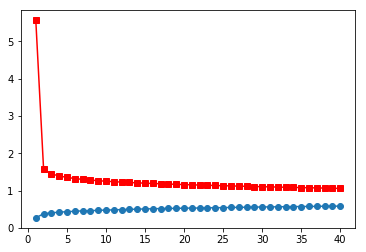

In [63]:
# accuracy_lst = [accuracy1[i].tolist()[0] for i in range(len(accuracy1))]
# loss_lst = [loss_np1[i].tolist()[0] for i in range(len(loss_np1))]
# epochs = [i+1 for i in range(num_epochs)]
# p1, ax = plt.subplots(1)
# # ax.set_ylim(bottom = 0)
# ax.plot(epochs, accuracy_lst, marker = 'o')
# ax.plot(epochs, loss_lst, 'r', marker = 's')
# plt.show(p1)


In [15]:
# Run Baseline CNN
# images, labels = extract_data('data/images_train.npy','data/labels_train.npy')
# x_train, y_train, x_val, y_val = create_validation(images, labels)
# train_set = torch.utils.data.TensorDataset(x_train, y_train)
# val_set = torch.utils.data.TensorDataset(x_val, y_val)
# train_loader = DataLoader(train_set, batch_size = 64)
# validation_loader = DataLoader(val_set, batch_size = 64)

# num_epochs = 40
# cnn= ConvolutionalNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adagrad(cnn.parameters(), lr = 0.001)

# accuracy2,loss_np2,val_accuracy2 = train_val_NN(cnn, train_loader, validation_loader, criterion, optimizer,num_epochs)
# print(val_accuracy2)

[[0.39230769]
 [0.39615385]
 [0.41346154]
 [0.44807692]
 [0.45961538]
 [0.48269231]
 [0.49807692]
 [0.51153846]
 [0.52307692]
 [0.52884615]
 [0.53461538]
 [0.54038462]
 [0.54423077]
 [0.54423077]
 [0.54423077]
 [0.55384615]
 [0.55769231]
 [0.55961538]
 [0.56153846]
 [0.56153846]
 [0.56346154]
 [0.56346154]
 [0.56346154]
 [0.56346154]
 [0.56923077]
 [0.57115385]
 [0.575     ]
 [0.58076923]
 [0.58076923]
 [0.58269231]
 [0.58269231]
 [0.58846154]
 [0.59038462]
 [0.59423077]
 [0.59615385]
 [0.59423077]
 [0.59423077]
 [0.59807692]
 [0.6       ]
 [0.6       ]]


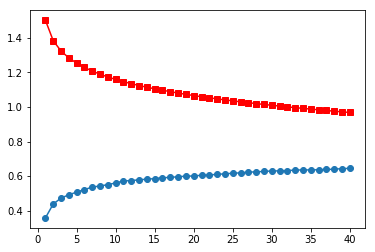

In [62]:
# accuracy_lst2 = [accuracy2[i].tolist()[0] for i in range(len(accuracy2))]
# loss_lst2 = [loss_np2[i].tolist()[0] for i in range(len(loss_np2))]
# epochs = [i+1 for i in range(num_epochs)]
# p2, ax = plt.subplots(1)
# ax.plot(epochs, accuracy_lst2, marker = 'o')
# ax.plot(epochs, loss_lst2, 'r', marker = 's')
# plt.show(p2)

In [25]:
# Run Baseline CNN on Normilized Images
# images, labels = extract_data('data/images_train.npy','data/labels_train.npy')
# x_train, y_train, x_val, y_val = create_validation(images, labels)
# train_set = torch.utils.data.TensorDataset(x_train, y_train)
# val_set = torch.utils.data.TensorDataset(x_val, y_val)
# train_loader = DataLoader(train_set, batch_size = 64)
# validation_loader = DataLoader(val_set, batch_size = 64)

# num_epochs = 40
# cnn= ConvolutionalNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adagrad(cnn.parameters(), lr = 0.001)

# accuracy3,loss_np3,val_accuracy3 = train_val_NN(cnn, train_loader, validation_loader, criterion, optimizer,num_epochs)
# print(val_accuracy3)


[[0.39807692]
 [0.40576923]
 [0.41346154]
 [0.42115385]
 [0.41923077]
 [0.42692308]
 [0.44615385]
 [0.45769231]
 [0.48269231]
 [0.48653846]
 [0.49807692]
 [0.51153846]
 [0.51153846]
 [0.52692308]
 [0.53076923]
 [0.52884615]
 [0.53269231]
 [0.54038462]
 [0.54615385]
 [0.54807692]
 [0.55      ]
 [0.55192308]
 [0.55384615]
 [0.55576923]
 [0.56153846]
 [0.56153846]
 [0.56538462]
 [0.56923077]
 [0.575     ]
 [0.57884615]
 [0.58076923]
 [0.58269231]
 [0.57884615]
 [0.58076923]
 [0.57884615]
 [0.58076923]
 [0.57884615]
 [0.58076923]
 [0.58653846]
 [0.58653846]]


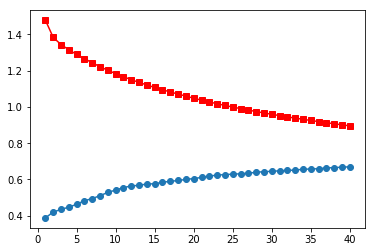

In [26]:
# accuracy_lst3 = [accuracy3[i].tolist()[0] for i in range(len(accuracy3))]
# loss_lst3 = [loss_np3[i].tolist()[0] for i in range(len(loss_np3))]
# epochs = [i+1 for i in range(num_epochs)]
# p3, ax = plot.subplots(1)
# ax.plot(epochs, accuracy_lst3, marker = 'o')
# ax.plot(epochs, loss_lst3, 'r', marker = 's')
# plt.show(p3)

In [189]:
# Choose from one of the above models and improve its performance
# Run Baseline CNN
# images, labels = extract_data('data/images_train.npy','data/labels_train.npy')
# x_train, y_train, x_val, y_val = create_validation(images, labels)
# train_set = torch.utils.data.TensorDataset(x_train, y_train)
# val_set = torch.utils.data.TensorDataset(x_val, y_val)
# train_loader = DataLoader(train_set, batch_size = 64)
# validation_loader = DataLoader(val_set, batch_size = 64)

# num_epochs = 40
# o_cnn= OptimizedNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(o_cnn.parameters(), lr = 0.001)

# accuracy4,loss_np4,val_accuracy4 = train_val_NN(o_cnn, train_loader, validation_loader, criterion, optimizer,num_epochs)
# print(val_accuracy4)

In [60]:
# accuracy_lst4 = [accuracy4[i].tolist()[0] for i in range(len(accuracy4))]
# loss_lst4 = [loss_np4[i].tolist()[0] for i in range(len(loss_np4))]
# epochs = [i+1 for i in range(num_epochs)]
# p4, ax = plot.subplots(1)
# # ax.set_ylim(bottom = 0)
# ax.plot(epochs, accuracy_lst4, marker = 'o')
# ax.plot(epochs, loss_lst4, 'r', marker = 's')
# plt.show(p4)

NameError: name 'plot' is not defined

In [56]:
# val_accuracy4

array([[0.34807692],
       [0.42115385],
       [0.50192308],
       [0.54615385],
       [0.54807692],
       [0.59615385],
       [0.62115385],
       [0.62307692],
       [0.61538462],
       [0.63653846],
       [0.64423077],
       [0.66538462],
       [0.66538462],
       [0.66730769],
       [0.67692308],
       [0.69807692],
       [0.68269231],
       [0.72115385],
       [0.71730769],
       [0.72884615],
       [0.72307692],
       [0.72884615],
       [0.75384615],
       [0.725     ],
       [0.73653846],
       [0.72692308],
       [0.73653846],
       [0.77115385],
       [0.775     ],
       [0.77115385],
       [0.78076923],
       [0.77692308],
       [0.78076923],
       [0.78076923],
       [0.77884615],
       [0.79423077],
       [0.78076923],
       [0.77884615],
       [0.79807692],
       [0.8       ]])

In [59]:
# val_accuracy4[-1]

array([0.8])